Import

In [1]:
import numpy as np
import pandas as pd

In [2]:
df_train = pd.read_csv("train.csv", index_col=False)
df_valid = pd.read_csv("valid.csv", index_col = False)
df_test = pd.read_csv("test.csv", index_col = False)

Reorder columns for model training

In [3]:
df_valid = df_valid.loc[:, df_train.columns]
df_test = df_test.loc[:, df_train.columns]

Split X/Y variables

In [4]:
y_train = df_train['FraudFound_P']
x_train = df_train.drop('FraudFound_P',axis = 1)
y_valid = df_valid['FraudFound_P']
x_valid = df_valid.drop('FraudFound_P',axis = 1)
y_test = df_test['FraudFound_P']
x_test = df_test.drop('FraudFound_P',axis = 1)

Oversampling and Undersampling

In [5]:
from collections import Counter
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0, sampling_strategy=0.6)

x_train, y_train = smote_enn.fit_resample(x_train, y_train)

In [6]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

### Tune For Recall

In [9]:
def create_model(trial):
    max_depth = trial.suggest_int('max_depth', 5, x_train.shape[1])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    zero_weight = trial.suggest_float('zero_weight', 0, 1)
    class_weight = {0: zero_weight, 1: 1-zero_weight}
    model = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state = 4012,
        class_weight = class_weight
        )
    return model

In [67]:
def model_performance(model, X = x_valid, y = y_valid):
    y_pred = model.predict(X)
    return round(metrics.recall_score(y, y_pred), 3)
def objective(trial):
    model = create_model(trial)
    model.fit(x_train, y_train)
    return model_performance(model)

In [69]:
import optuna
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200, timeout = 600)

[I 2022-11-13 23:06:41,916] A new study created in memory with name: no-name-00e43ffc-7c5f-4ad7-922b-d1d95a5447ef
[I 2022-11-13 23:06:42,152] Trial 0 finished with value: 0.358 and parameters: {'max_depth': 40, 'min_samples_split': 14, 'min_samples_leaf': 12, 'zero_weight': 0.5311423805182848}. Best is trial 0 with value: 0.358.
[I 2022-11-13 23:06:42,356] Trial 1 finished with value: 0.366 and parameters: {'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 4, 'zero_weight': 0.4166600839569873}. Best is trial 1 with value: 0.366.
[I 2022-11-13 23:06:42,552] Trial 2 finished with value: 0.201 and parameters: {'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 16, 'zero_weight': 0.9222454024252384}. Best is trial 1 with value: 0.366.
[I 2022-11-13 23:06:42,752] Trial 3 finished with value: 0.261 and parameters: {'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 9, 'zero_weight': 0.693410107352649}. Best is trial 1 with value: 0.366.
[I 2022-11-13 23:06:4

In [71]:
best_model = create_model(study.best_trial)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_valid)
print(metrics.classification_report(y_valid, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9989    0.4397    0.6106      2131
           1     0.1002    0.9925    0.1821       134

    accuracy                         0.4724      2265
   macro avg     0.5496    0.7161    0.3963      2265
weighted avg     0.9458    0.4724    0.5853      2265



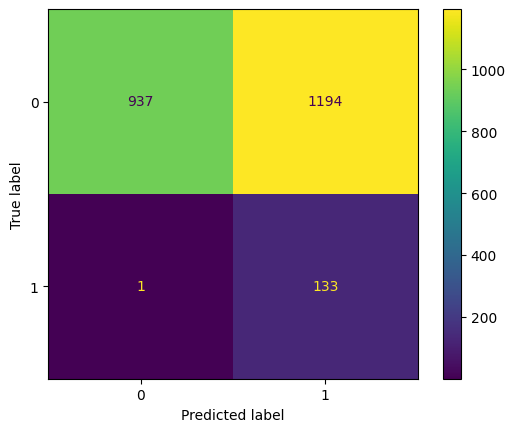

In [72]:
#Ploting the confusion matrix
cm=metrics.confusion_matrix(y_valid,y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Tune For fbeta

In [7]:
def model_performance(model, X = x_valid, y = y_valid):
    y_pred = model.predict(X)
    fbeta = metrics.fbeta_score(y, y_pred, beta = 2)
    return fbeta

def objective(trial):
    model = create_model(trial)
    model.fit(x_train, y_train)
    return model_performance(model)

In [10]:
# %pip install optuna
import optuna
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200, timeout = 600)


[I 2022-11-13 23:42:18,179] A new study created in memory with name: no-name-feb0cf2d-ecf3-406e-984a-797335a22c6c
[I 2022-11-13 23:42:18,363] Trial 0 finished with value: 0.1938610662358643 and parameters: {'max_depth': 21, 'min_samples_split': 20, 'min_samples_leaf': 16, 'zero_weight': 0.9338202870990455}. Best is trial 0 with value: 0.1938610662358643.
[I 2022-11-13 23:42:18,531] Trial 1 finished with value: 0.3849114703618167 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 17, 'zero_weight': 0.12810868863109026}. Best is trial 1 with value: 0.3849114703618167.
[I 2022-11-13 23:42:18,696] Trial 2 finished with value: 0.297029702970297 and parameters: {'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 9, 'zero_weight': 0.5040327786196742}. Best is trial 1 with value: 0.3849114703618167.
[I 2022-11-13 23:42:18,896] Trial 3 finished with value: 0.26785714285714285 and parameters: {'max_depth': 51, 'min_samples_split': 11, 'min_samples_leaf': 15, 

In [11]:
best_model = create_model(study.best_trial)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_valid)
print(metrics.classification_report(y_valid,y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9844    0.7114    0.8259      2131
           1     0.1517    0.8209    0.2561       134

    accuracy                         0.7179      2265
   macro avg     0.5681    0.7661    0.5410      2265
weighted avg     0.9352    0.7179    0.7922      2265



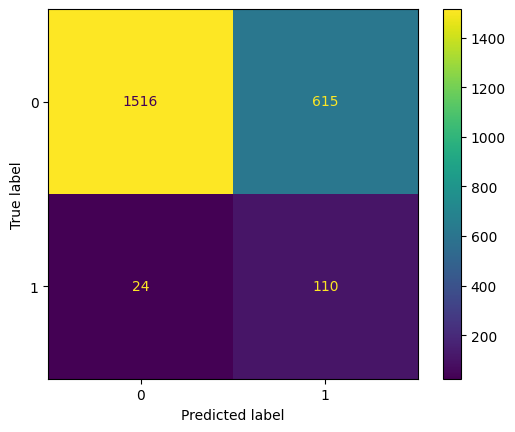

In [12]:
#Ploting the confusion matrix
cm=metrics.confusion_matrix(y_valid,y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [13]:
study.best_params

{'max_depth': 6,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'zero_weight': 0.42115403931183315}

In [14]:
feature_impt = pd.DataFrame({'feature name':best_model.feature_names_in_, 'feature importance':best_model.feature_importances_})
not_impt = feature_impt.sort_values('feature importance').iloc[0:5,:]
print(not_impt)

   feature name  feature importance
26  Make_Jaguar                 0.0
21     Make_BMW                 0.0
23   Make_Dodge                 0.0
24    Make_Ford                 0.0
25   Make_Honda                 0.0


Variables
PolicyType_Sedan - Liability    0.407200
Fault_IsPolicyholder            0.232138
Deductible                      0.140068
PolicyType_Sedan - Collision    0.052522
Year                            0.028705
Make_Pontiac                    0.021783
Make_Toyota                     0.020327
Make_Mazda                      0.017544
VehiclePrice                    0.016402
MonthClaimed                    0.016138
Name: Importance, dtype: float64


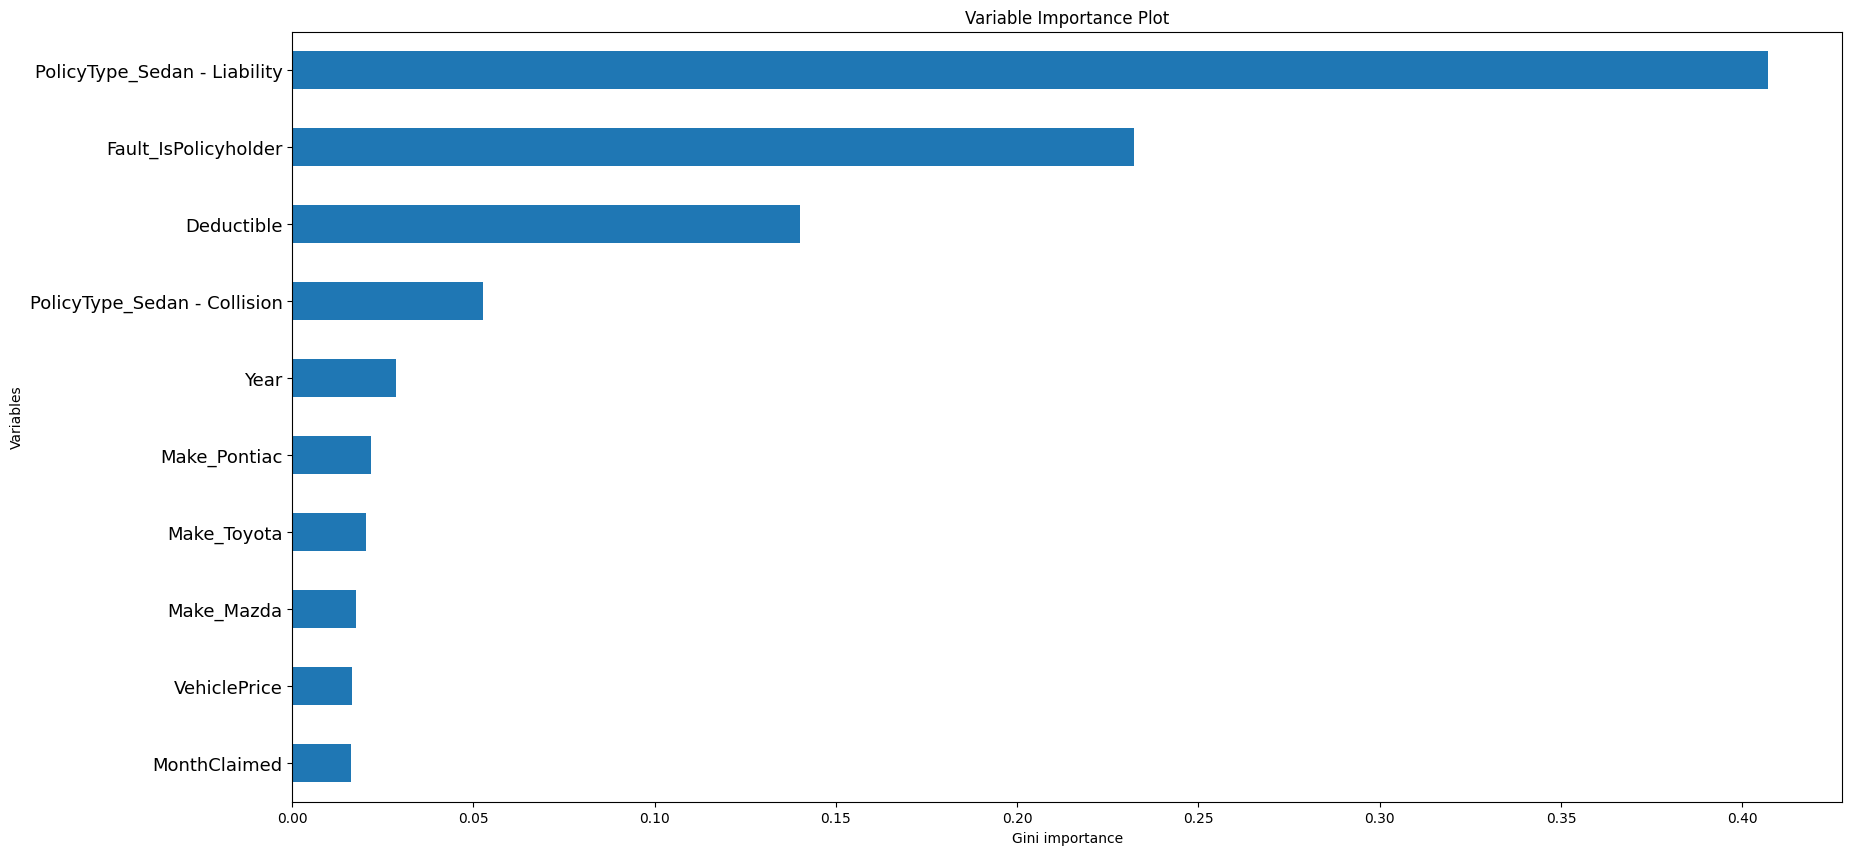

In [15]:
import matplotlib.pyplot as plt
model_ranks = pd.Series(best_model.feature_importances_, index=x_train.columns, name='Importance').sort_values(ascending=False, inplace=False)
model_ranks.index.name = 'Variables'
top_features = model_ranks.iloc[:10].sort_values(ascending=True, inplace=False)
plt.figure(figsize=(20,10))
ax = top_features.plot(kind='barh')
ax.set_title('Variable Importance Plot')
ax.set_xlabel('Gini importance')
ax.set_yticklabels(top_features.index, fontsize=13)

print(top_features.sort_values(ascending=False))

In [16]:
# remove feature importance == 0
not_impt['feature name']
x_train = x_train.drop(not_impt['feature name'], axis = 1)
x_valid = x_valid.drop(not_impt['feature name'], axis = 1)
x_test = x_test.drop(not_impt['feature name'], axis = 1)

In [17]:
x_train

,MonthClaimed,VehiclePrice,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,NumberOfSuppliments,...,PolicyType_Sedan - Collision,PolicyType_Sedan - Liability,PolicyType_Sport - All Perils,PolicyType_Sport - Collision,PolicyType_Utility - All Perils,PolicyType_Utility - Collision,PolicyType_Utility - Liability,Make_Ferrari,PolicyType_Sport - Liability,Normalised_Age
0,2.000000,1.000000,1.0,1.000000,4.0,2.0,0.000000,6.000000,5.000000,3.000000,...,0,0,0,0,0,0,0,0,0,0.427219
1,5.000000,1.000000,1.0,1.000000,4.0,2.0,3.000000,5.000000,3.000000,3.000000,...,0,1,0,0,0,0,0,0,0,-0.546320
2,4.000000,1.000000,1.0,0.000000,4.0,2.0,2.000000,6.000000,3.000000,0.000000,...,0,1,0,0,0,0,0,0,0,-0.789705
3,0.000000,5.000000,1.0,0.000000,4.0,2.0,2.000000,4.000000,3.000000,1.000000,...,0,1,0,0,0,0,0,0,0,-0.870833
4,11.000000,1.000000,1.0,0.000000,4.0,2.0,3.000000,5.000000,3.000000,0.000000,...,0,1,0,0,0,0,0,0,0,-0.708577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12526,3.930081,1.000000,1.0,0.069919,4.0,2.0,1.000000,6.000000,4.000000,0.930081,...,0,0,0,0,0,0,0,0,0,-0.199118
12527,5.000000,1.000000,1.0,2.888695,4.0,2.0,0.000000,2.166958,2.000000,0.055653,...,0,0,0,0,0,0,0,0,0,-1.276475
12528,4.000000,1.000000,1.0,3.000000,4.0,2.0,1.637323,5.637323,3.637323,3.000000,...,0,0,0,0,0,0,0,0,0,-0.501757
12529,3.939469,2.060531,1.0,2.060531,4.0,2.0,1.060531,6.060531,5.939469,1.939469,...,1,0,0,0,0,0,0,0,0,1.209037


In [18]:
def create_model(trial):
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    zero_weight = trial.suggest_float('zero_weight', 0, 1)
    class_weight = {0: zero_weight, 1: 1-zero_weight}
    model = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state = 4012,
        class_weight = class_weight
        )
    return model
def model_performance(model, X = x_valid, y = y_valid):
    y_pred = model.predict(X)
    return metrics.fbeta_score(y, y_pred, beta = 2)
def objective(trial):
    model = create_model(trial)
    model.fit(x_train, y_train)
    return model_performance(model)

In [19]:
import optuna
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200, timeout = 600)

[I 2022-11-13 23:43:51,073] A new study created in memory with name: no-name-27bf8d05-ed5c-4c75-ade2-aad459543c3f
[I 2022-11-13 23:43:51,250] Trial 0 finished with value: 0.36672629695885506 and parameters: {'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 2, 'zero_weight': 0.24274859924985703}. Best is trial 0 with value: 0.36672629695885506.
[I 2022-11-13 23:43:51,338] Trial 1 finished with value: 0.3657556270096463 and parameters: {'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 13, 'zero_weight': 0.5577592241382218}. Best is trial 0 with value: 0.36672629695885506.
[I 2022-11-13 23:43:51,470] Trial 2 finished with value: 0.2294303797468354 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'zero_weight': 0.8988907400396282}. Best is trial 0 with value: 0.36672629695885506.
[I 2022-11-13 23:43:51,590] Trial 3 finished with value: 0.4207920792079208 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 15, 

In [100]:
best_model = create_model(study.best_trial)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_valid)
print(metrics.classification_report(y_valid,y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.9845    0.7137    0.8275      2131
           1     0.1528    0.8209    0.2576       134

    accuracy                         0.7201      2265
   macro avg     0.5686    0.7673    0.5426      2265
weighted avg     0.9353    0.7201    0.7938      2265



A very slight improvement in precision after feature selection

## GaussianNB

In [28]:
from sklearn.naive_bayes import GaussianNB
bn = GaussianNB()
bn.fit(x_train, y_train)
print(metrics.classification_report(y_test, bn.predict(x_test)))
print(metrics.fbeta_score(y_test, bn.predict(x_test), beta = 0.75))
print(metrics.recall_score(y_test, bn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.98      0.28      0.44      2131
           1       0.07      0.93      0.14       134

    accuracy                           0.32      2265
   macro avg       0.53      0.60      0.29      2265
weighted avg       0.93      0.32      0.42      2265

0.11184068114582581
0.9253731343283582
